# Strava, Rouvy and Machine Learning

### How to predict 'moving time' on a route by Scikit-Learn
<center><img src="strava.png" alt="My Account from Strava web page" /><img src="rouvy.png" alt="My Account from Strava web page" /></center>

I've had a lot of fun riding my bike over the last few years. Unfortunately the Covid pandemic has greatly limited the opportunities for outdoor outings. Plus the winter is harsh in my area. So I subscribed to a nice app called (rouvy.com) and bought an indoor trainer to pedal at home. 

It was a fantastic experience that continues to this day. Early every day in the morning I can train by pedaling anywhere in the world, tackling the steepest and most legendary climbs. 

I connected Rouvy to my (free) Strava account so that every route I ride under Rouvy is automatically saved to Strava. After 3 years the end result is that I have more than 500 routes (indoor and outdoor) saved in my Strava account. But how does Machine Learning come into play?

When I want to choose the next route to take, I often have only a rough idea of the "commute time" it will take. It would be helpful to have some Moving time prediction to better schedule my time. So I decided to use the data available in Strava to train some Machine Learning models and predict the "commute time" (also 'Moving time') given some parameters (distance, elevation gain, max grade, average grade...) of the route. This data are available 'a priori' in the Rouvy profile of the route.
The notebook, the data and all the pictures are available under my github https://github.com/fabioantonini/strava-moving-time-regressor.

## Outline
Here the topics we are going to talk.

- ### Retrieving data from Strava
- ### Data Exlporation
- ### Data Cleaning
- ### Selecting Features and Labels
- ### Outliers
- ### Save the cleaned data
- ### Data Visualization
- ### Looking for correlation
- ### Avoiding sampling bias
- ### Splitting Training and Test sets
- ### Linear Regression Model
- ### Decision Tree Model
- ### Random Forest Model
- ### Challenge Gunsan-Saemangeum 2002 prediction
- ### Fine-Tune Your Model
- ### Conclusions

## Retrieving data from Strava

The routes data can be exported by the Strava website from the 'My Account' page.

<center><img src="myaccount.png" alt="My Account from Strava web page" /></center>

Search for 'Download or Delete Your Account'. Click on the 'Get Started'.

<img src="export.png" alt="My Account from Strava web page" />

Click on the 'Request Your Archive' button. As explained, an email will be sent to you with the link to download the zip file containing the data of your Strava activities. Prepare to wait for a while. Strava takes its time to arrange the archive. So you might receive the email after some hours.
Anyway in the end you will receive the email and download the zip file (export_31174850.zip for instance).
Let's take a look at its content.

<img src="zipfile.png" alt="My Account from Strava web page" />

For our purposes only the 'activities.csv' file is required. From the size we can realize that it contains a lot of data. My own 'activities.csv' file has been added to the repo and it will be processed next. Let's import it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression # Regression Model
from sklearn.model_selection import train_test_split # to split train and test sets
plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

In [2]:
activities = pd.read_csv("activities.csv")
print("dataset type is:", type(activities), "length:", len(activities), "shape:", activities.shape)

dataset type is: <class 'pandas.core.frame.DataFrame'> length: 855 shape: (855, 86)


## Data exploration

The dataset is made of 855 activities (rows), but unfortunately not all of them are rides by bike.

The single route (row) includes 86 columns. Not all the columns contain usable data (many NaN or 'null' are present) because I don't have a full Strava subscription, but only a free account. 

Let's take a look more in depth to undestand which activities are really useful to our purpose.

In [3]:
print("columns: ", len(list(activities.columns)))

columns:  86


In [4]:
activities.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1676508527,"Jul 2, 2018, 5:14:47 PM",Evening Ride,Ride,NaN,2967,16.11,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1688313611,"Jul 8, 2018, 8:05:24 AM",Giro del 29,Ride,NaN,5620,38.19,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1713633869,"Jul 19, 2018, 3:50:13 PM",Giro in solitaria,Ride,NaN,6920,38.43,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,8.550000e+02,855.000000,855.000000,363.000000,363.000000,93.0,584.0,848.000000,855.000000,855.000000,...,0.0,0.0,0.0,455.0,505.000000,428.000000,0.0,0.0,0.0,0.0
mean,5.882504e+09,4896.778947,23.197427,161.672176,77.801653,0.0,8.0,4844.685142,4033.011696,23200.878327,...,NaN,NaN,NaN,0.0,5.331706,934.361921,NaN,NaN,NaN,NaN
std,1.821269e+09,4781.126901,23.487286,15.338356,72.361770,0.0,0.0,4730.428535,3668.496186,23487.188138,...,NaN,NaN,NaN,0.0,3.481276,2573.152478,NaN,NaN,NaN,NaN
min,1.658492e+09,25.000000,0.000000,94.000000,0.000000,0.0,8.0,25.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,4.465294e+09,1668.000000,5.175000,158.000000,23.500000,0.0,8.0,1657.250000,1280.000000,5178.875000,...,NaN,NaN,NaN,0.0,1.635582,0.000000,NaN,NaN,NaN,NaN
50%,6.117119e+09,3765.000000,15.500000,162.000000,61.000000,0.0,8.0,3725.500000,3246.000000,15499.469727,...,NaN,NaN,NaN,0.0,5.760333,0.000000,NaN,NaN,NaN,NaN
75%,7.559050e+09,6452.500000,34.230000,166.500000,118.000000,0.0,8.0,6403.500000,5482.500000,34230.169922,...,NaN,NaN,NaN,0.0,8.220940,265.899994,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


We need to extract only the columns really useful to train a model.
The data appear to be a bit sparsed. Some columns are not valorized at all (because of my free account). Others columns have many 'null' values. We need to identify only the features statistically helpful that are available for each route before riding the route itself.

Let's clean the data.

## Data cleaning

In the next section data will be cleaned and filtered to get only routes done by bike (Outdoor and Indoor).

### Getting only activities done by bike

We defintely need to get only the activities done by bike. They are labeled as 'Ride' and 'Virtual Ride' in the Strava exported dataset. So we will drop the activities tagged as 'Walk' and 'Run'.

In [6]:
activities=activities.loc[activities['Activity Type'].isin(['Ride', 'Virtual Ride'])]

In [7]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,7.090000e+02,709.000000,709.00000,363.000000,363.000000,87.0,584.0,702.000000,709.000000,709.000000,...,0.0,0.0,0.0,368.0,401.000000,347.000000,0.0,0.0,0.0,0.0
mean,5.809251e+09,4701.454161,26.86653,161.672176,77.801653,0.0,8.0,4636.578348,4212.152327,26869.856557,...,NaN,NaN,NaN,0.0,6.463675,570.186459,NaN,NaN,NaN,NaN
std,1.869153e+09,4906.990907,24.17435,15.338356,72.361770,0.0,0.0,4845.838532,3848.993731,24174.349129,...,NaN,NaN,NaN,0.0,2.996792,2308.845122,NaN,NaN,NaN,NaN
min,1.658492e+09,25.000000,0.00000,94.000000,0.000000,0.0,8.0,25.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,4.370928e+09,1311.000000,9.48000,158.000000,23.500000,0.0,8.0,1279.500000,1281.000000,9479.799805,...,NaN,NaN,NaN,0.0,4.589389,0.000000,NaN,NaN,NaN,NaN
50%,6.033487e+09,3448.000000,21.18000,162.000000,61.000000,0.0,8.0,3408.000000,3368.000000,21179.599609,...,NaN,NaN,NaN,0.0,6.811444,0.000000,NaN,NaN,NaN,NaN
75%,7.557703e+09,6190.000000,39.42000,166.500000,118.000000,0.0,8.0,6012.500000,5614.000000,39419.601562,...,NaN,NaN,NaN,0.0,8.603601,0.000000,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.01000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


You can notice that the number of rows decreased a bit. Let's go further.

In [8]:
# as an alternative you can remove the 'Walk' and 'Run' activities
# activities = activities.drop(activities[activities['Activity Type'] == 'Walk'].index)
# activities = activities.drop(activities[activities['Activity Type'] == 'Run'].index)

### Removing short routes

When you ride under Rouvy you can optionally have a 'Warm up' and 'Cool down' before and after respectively the selected route. Also these short routes have been recorded under Strava. They are not useful for our purposes. So let's remove all the routes whose 'Moving Time' is less than 3 minutes (180 secs).

In [9]:
activities = activities.drop(activities[activities['Moving Time'] < 180].index)

In [10]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,6.220000e+02,622.000000,622.000000,309.000000,309.000000,87.0,497.0,615.000000,622.000000,622.000000,...,0.0,0.0,0.0,293.0,324.000000,273.000000,0.0,0.0,0.0,0.0
mean,5.603504e+09,5348.432476,30.572412,162.721683,91.090615,0.0,8.0,5281.743089,4791.000000,30575.799413,...,NaN,NaN,NaN,0.0,6.974121,724.742495,NaN,NaN,NaN,NaN
std,1.858750e+09,4902.548491,23.540469,15.412095,70.448504,0.0,0.0,4842.017346,3762.325433,23540.386354,...,NaN,NaN,NaN,0.0,2.760826,2582.367621,NaN,NaN,NaN,NaN
min,1.658492e+09,183.000000,0.000000,94.000000,0.000000,0.0,8.0,183.000000,183.000000,0.000000,...,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,4.252221e+09,2159.250000,11.852500,158.000000,36.000000,0.0,8.0,2152.000000,2146.000000,11857.300049,...,NaN,NaN,NaN,0.0,5.021870,0.000000,NaN,NaN,NaN,NaN
50%,5.710567e+09,4028.500000,25.510000,163.000000,74.000000,0.0,8.0,3998.000000,3861.500000,25517.599609,...,NaN,NaN,NaN,0.0,7.473115,0.000000,NaN,NaN,NaN,NaN
75%,7.273470e+09,6950.000000,40.565000,167.000000,136.000000,0.0,8.0,6892.000000,6176.000000,40567.200195,...,NaN,NaN,NaN,0.0,8.806412,17.299999,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


The count number has decreased again.

### Handling fake data

Inspecting the original dataframe we can realize that there are some bad data. For instance it's hard to believe that the 'Max Grade' is 50%. If the min 'Distance' is 0 Km, the route is a 'fake' or the data are corrupted. So these routes can be removed.
Let's clean this data by setting a threshold of 25% for the 'Max Grade', and 3 Km's for 'Distance' respectively.

In [11]:
activities = activities.drop(activities[activities['Max Grade'] > 25].index)

In [12]:
activities = activities.drop(activities[activities['Distance'] < 3].index)

In [13]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,5.330000e+02,533.000000,533.000000,279.000000,279.000000,67.0,436.0,526.000000,533.000000,533.000000,...,0.0,0.0,0.0,259.0,289.000000,241.000000,0.0,0.0,0.0,0.0
mean,5.695413e+09,5316.257036,31.164128,163.906810,92.480287,0.0,8.0,5237.855513,4772.129456,31167.503775,...,NaN,NaN,NaN,0.0,7.299034,730.412868,NaN,NaN,NaN,NaN
std,1.802294e+09,4826.064501,22.453891,14.855367,69.298791,0.0,0.0,4752.383038,3592.336780,22453.795613,...,NaN,NaN,NaN,0.0,2.608758,2655.567022,NaN,NaN,NaN,NaN
min,1.658492e+09,308.000000,3.000000,94.000000,0.000000,0.0,8.0,308.000000,308.000000,3008.449951,...,NaN,NaN,NaN,0.0,1.032541,0.000000,NaN,NaN,NaN,NaN
25%,4.305707e+09,2209.000000,13.260000,159.000000,38.000000,0.0,8.0,2191.750000,2186.000000,13259.000000,...,NaN,NaN,NaN,0.0,5.544992,0.000000,NaN,NaN,NaN,NaN
50%,5.840924e+09,3986.000000,26.270000,163.000000,74.000000,0.0,8.0,3974.000000,3849.000000,26270.500000,...,NaN,NaN,NaN,0.0,7.755432,0.000000,NaN,NaN,NaN,NaN
75%,7.289805e+09,6620.000000,40.280000,168.000000,135.500000,0.0,8.0,6432.750000,6029.000000,40280.300781,...,NaN,NaN,NaN,0.0,9.003734,21.299999,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


Now we have 533 bike routes (Indoor and Outdoor). Let's take a look.

In [14]:
activities.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1719724545,"Jul 22, 2018, 7:04:42 AM",Forca caruso,Ride,NaN,13342,56.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1805770005,"Aug 29, 2018, 4:19:28 PM",Antrisano Magliano Tagliacozzo e ritorno,Ride,NaN,4639,34.89,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1813283516,"Aug 30, 2018, 4:20:19 PM",Giro con pioggia,Ride,NaN,2159,9.82,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now the data looks better. It's time to get the features really helpful to train our models.

## Handling 'Null' values

We can check the 'null' values.

In [15]:
null_rows_idx = activities.isnull().any(axis=1)
activities.loc[null_rows_idx].head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1719724545,"Jul 22, 2018, 7:04:42 AM",Forca caruso,Ride,NaN,13342,56.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1805770005,"Aug 29, 2018, 4:19:28 PM",Antrisano Magliano Tagliacozzo e ritorno,Ride,NaN,4639,34.89,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1813283516,"Aug 30, 2018, 4:20:19 PM",Giro con pioggia,Ride,NaN,2159,9.82,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have a couple of policies to handle the 'Null' values.

We can use 'imputation' to set the NaN to the median value of that feature. A more rude approach is to remove the rows with at least one NaN or null value, but in this  case we will lost some data.

Let's try to use imputation in order to save the three rows with NaN values.

#### Imputation

In [16]:
median = activities["Elevation Gain"].median()
activities["Elevation Gain"].fillna(median, inplace=True)  # option 3

median = activities["Max Grade"].median()
activities["Max Grade"].fillna(median, inplace=True)  # option 3

activities.loc[null_rows_idx].head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1719724545,"Jul 22, 2018, 7:04:42 AM",Forca caruso,Ride,NaN,13342,56.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1805770005,"Aug 29, 2018, 4:19:28 PM",Antrisano Magliano Tagliacozzo e ritorno,Ride,NaN,4639,34.89,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1813283516,"Aug 30, 2018, 4:20:19 PM",Giro con pioggia,Ride,NaN,2159,9.82,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Droping NaN

You can remove the rows with at least one 'null' value.

In [17]:
#if activities.isnull().values.any():
#    activities=activities.dropna()

In [18]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,5.330000e+02,533.000000,533.000000,279.000000,279.000000,67.0,436.0,526.000000,533.000000,533.000000,...,0.0,0.0,0.0,259.0,289.000000,241.000000,0.0,0.0,0.0,0.0
mean,5.695413e+09,5316.257036,31.164128,163.906810,92.480287,0.0,8.0,5237.855513,4772.129456,31167.503775,...,NaN,NaN,NaN,0.0,7.299034,730.412868,NaN,NaN,NaN,NaN
std,1.802294e+09,4826.064501,22.453891,14.855367,69.298791,0.0,0.0,4752.383038,3592.336780,22453.795613,...,NaN,NaN,NaN,0.0,2.608758,2655.567022,NaN,NaN,NaN,NaN
min,1.658492e+09,308.000000,3.000000,94.000000,0.000000,0.0,8.0,308.000000,308.000000,3008.449951,...,NaN,NaN,NaN,0.0,1.032541,0.000000,NaN,NaN,NaN,NaN
25%,4.305707e+09,2209.000000,13.260000,159.000000,38.000000,0.0,8.0,2191.750000,2186.000000,13259.000000,...,NaN,NaN,NaN,0.0,5.544992,0.000000,NaN,NaN,NaN,NaN
50%,5.840924e+09,3986.000000,26.270000,163.000000,74.000000,0.0,8.0,3974.000000,3849.000000,26270.500000,...,NaN,NaN,NaN,0.0,7.755432,0.000000,NaN,NaN,NaN,NaN
75%,7.289805e+09,6620.000000,40.280000,168.000000,135.500000,0.0,8.0,6432.750000,6029.000000,40280.300781,...,NaN,NaN,NaN,0.0,9.003734,21.299999,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


We have 533 records (rows) that can be used to train our models.

## Selecting features and labels

After a fast analysis of the available features, only the following features will be used to train the model:
- Distance
- Elevation gain
- Max Grade
- Average Grade

The target label is the 'Moving Time'.

- For sure we expect there is some dependency between the 'Distance' and the 'Moving Time' (the longer the route, the longer it takes to complete it). 
- Higher is 'Elevation Gain 'of the route (even if the 'Distance' is small), the longer it takes to complete it.
- Also the 'Max Grade' is a variable related to the 'Moving Time': a short route with a small 'Evevation Gain' can take a long to time be completed if there are few KM's with a strong climb.
- The dataset includes outdoor (recorded from live) routes and indoor routes (recorded by Rouvy). For the outdoor route the 'Average Grade' is close to '0' because I go back home everytime. For indoor routes the 'Average Grade' can be greater than '0' as in the picture here below.

All these informations can be retrieved by Rouvy, for every available route.
Please note that in the picture the Elevation Gain is mapped to the 'Ascended' item.

In the next predictions examples we will get the route data from Rouvy and use them to make prediction of the 'Moving Time'. These additional routes are not included in the original dataset.

<center><img src="rouvy-route.png" alt="Rouvy data for a route" /></center>

In [19]:
activities = activities[["Distance", "Elevation Gain", "Max Grade", "Average Grade", "Moving Time"]]
activities.describe()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time
count,533.000000,533.000000,533.000000,533.000000,533.000000
mean,31.164128,415.124636,10.682325,0.853460,4772.129456
std,22.453891,356.731804,5.295872,2.266097,3592.336780
min,3.000000,0.000000,0.000000,-7.224899,308.000000
25%,13.260000,142.000000,6.906785,-0.008668,2186.000000
50%,26.270000,316.254242,11.000000,0.002732,3849.000000
75%,40.280000,610.183350,14.271695,0.519681,6029.000000
max,118.010000,2275.000000,24.799999,11.200340,21230.000000


## Outliers

Now let's drop some outliers:

In [20]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(activities)

In [21]:
#outlier_pred

In [22]:
#activities = activities.iloc[outlier_pred == 1]
#activities.describe()

## Save the cleaned data

Now the dataset has been cleaned and filtered. We will develop some models using this data.
The dataframe can be stored to the filesystem.

In [23]:
activities.to_csv('cleaned_activities.csv')

In [24]:
activities.head()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time
0,59.08,412.800842,9.4,0.000169,10637.0
2,35.56,114.721718,11.1,-0.001125,5067.0
5,56.41,574.050659,11.9,-0.001950,11906.0
12,34.89,207.574387,10.6,0.001146,4466.0
13,9.82,41.745453,6.6,-0.360192,1978.0


Let's take a look at the dataframe after the last processing.

## Visualization

We can obtain a first impression of the dependency between variables by examining a multidimensional scatterplot.

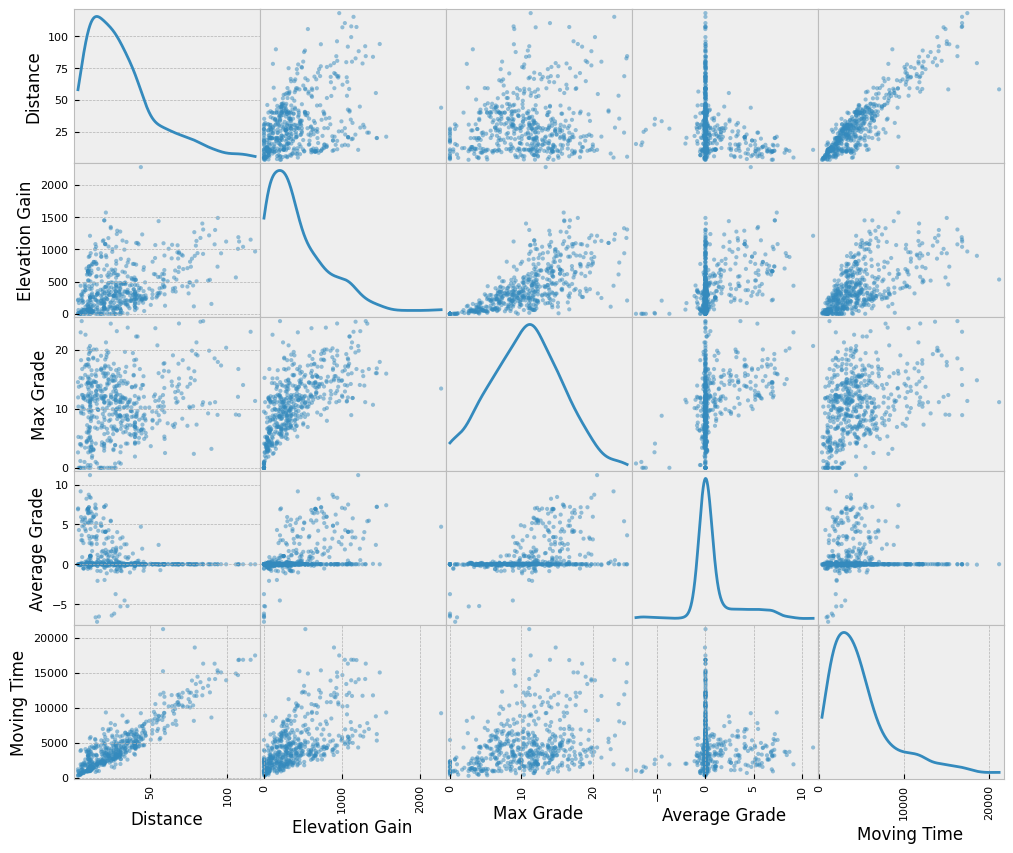

In [25]:
from pandas.plotting import scatter_matrix
scatter_matrix(activities, diagonal="kde", figsize=(12,10));

As expected we can see a linear relationship between the Moving Time and the Distance.

<AxesSubplot: xlabel='Distance', ylabel='Moving Time'>

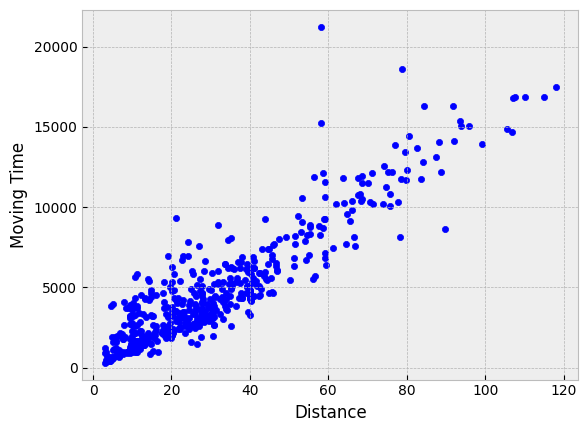

In [26]:
activities.plot(kind="scatter", x='Distance', y='Moving Time', grid=True)

there is an approximately linear relationship between Elevation Gain and the Distance: more Kms more the overall gain in altitude

<AxesSubplot: xlabel='Distance', ylabel='Elevation Gain'>

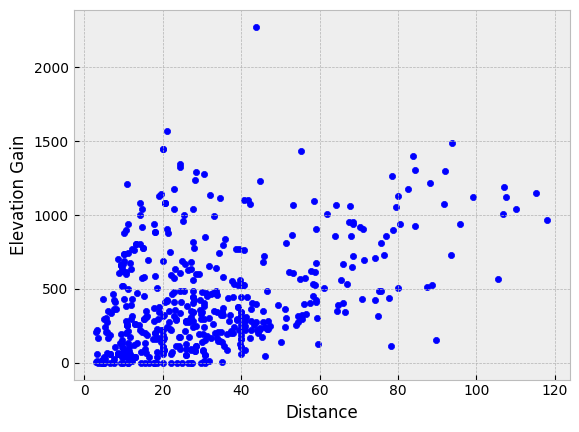

In [27]:
activities.plot(kind="scatter", x='Distance', y='Elevation Gain', grid=True)

We can also generate a 3D plot of the observations, which can sometimes help to interpret the data more easily. Here we plot 'Moving Time' as a function of 'Distance' and 'Elevation Gain'.

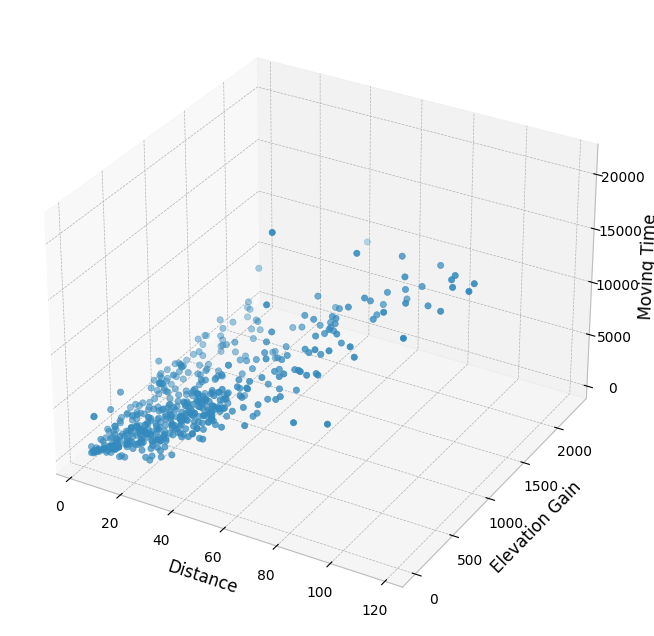

In [28]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(activities["Distance"], activities["Elevation Gain"], activities["Moving Time"])
ax.set_xlabel("Distance")
ax.set_ylabel("Elevation Gain")
ax.set_zlabel("Moving Time")
ax.set_facecolor("white")

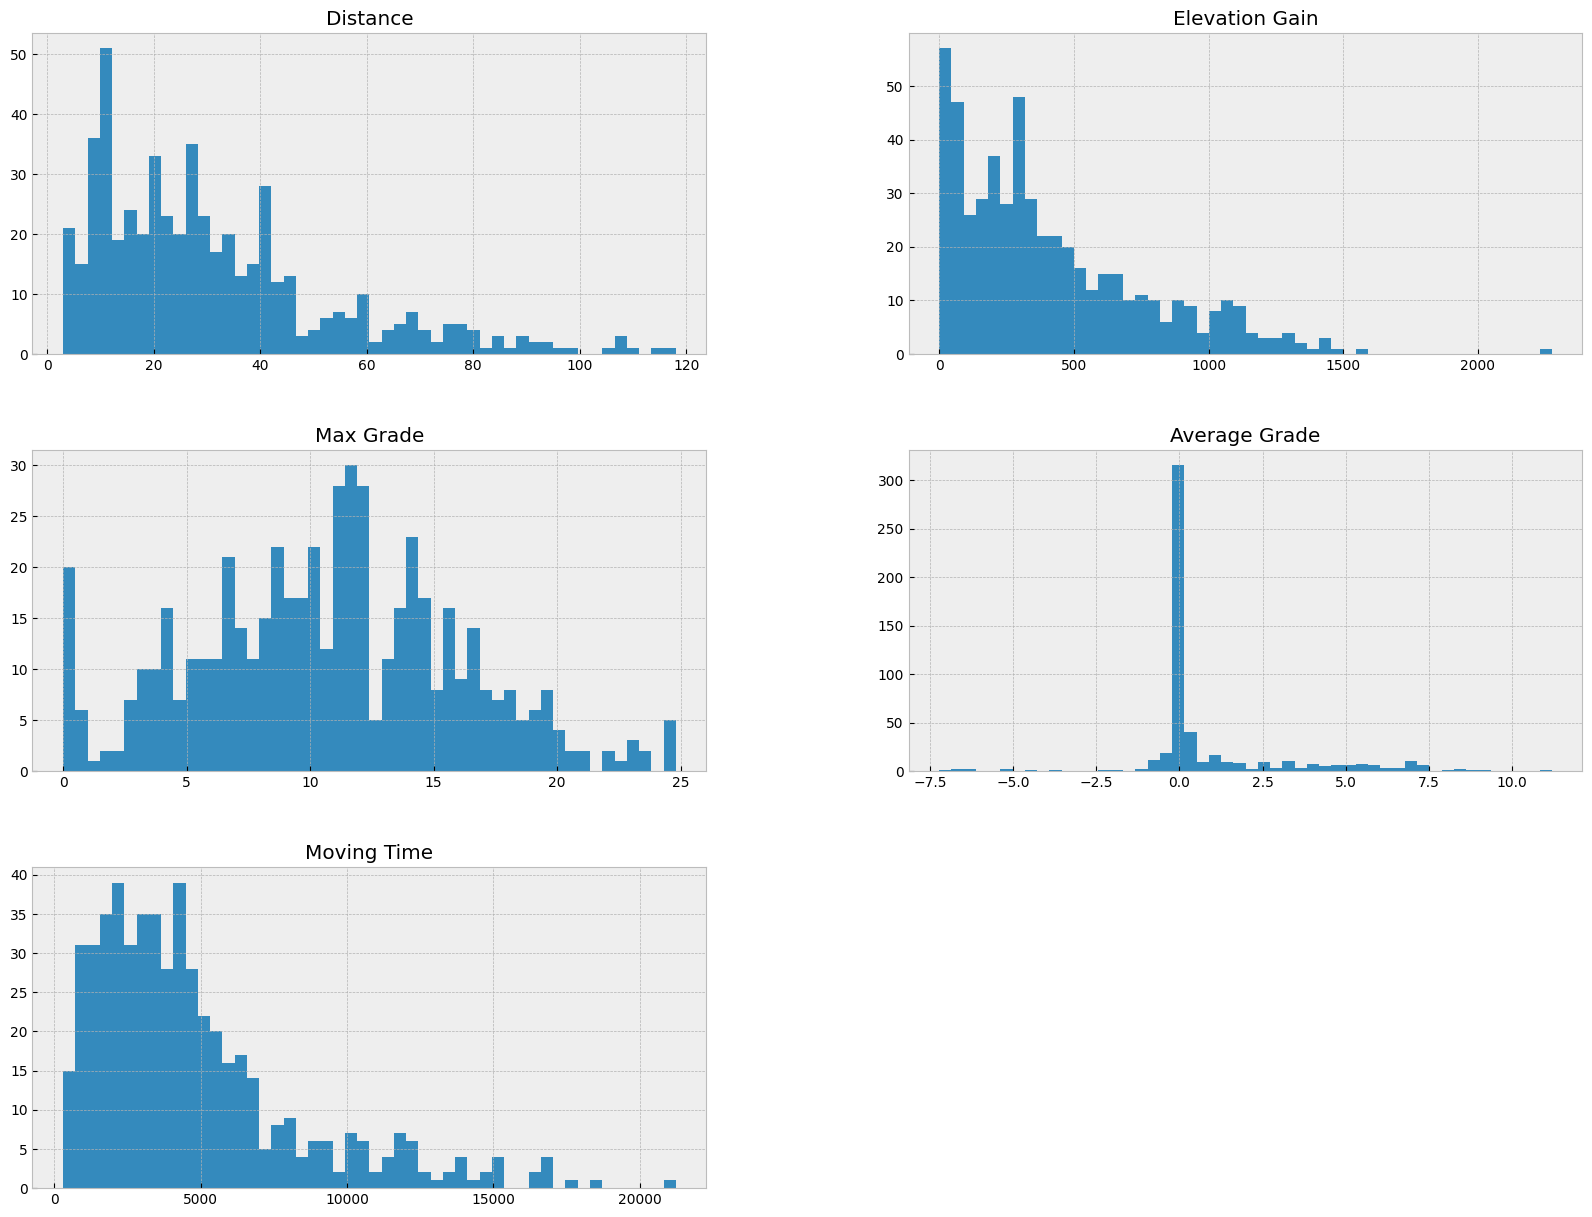

In [29]:
%matplotlib inline
activities.hist(bins=50, figsize=(20,15))
plt.show()

## Looking for correlation

You can easily compute the standard correlation coefficient (also called Pearson's r) between every pair of attributes using the 'corr()' method.

In [30]:
corr_matrix= activities.corr()

In [31]:
corr_matrix["Moving Time"].sort_values(ascending=False)

Moving Time       1.000000
Distance          0.909245
Elevation Gain    0.621053
Max Grade         0.357564
Average Grade    -0.065905
Name: Moving Time, dtype: float64

The Moving Time is strongly correlated to the 'Distance' and also to the 'Elevation Gain'. This is asbolutely expected.

We can notice that the 'Max Grade' is weakly correlated to the 'Moving Time'.
The 'Average Grade' is not correlated at all. So we decide to remove it.

In [32]:
activities.drop('Average Grade', inplace=True, axis=1)
activities.describe()

,Distance,Elevation Gain,Max Grade,Moving Time
count,533.000000,533.000000,533.000000,533.000000
mean,31.164128,415.124636,10.682325,4772.129456
std,22.453891,356.731804,5.295872,3592.336780
min,3.000000,0.000000,0.000000,308.000000
25%,13.260000,142.000000,6.906785,2186.000000
50%,26.270000,316.254242,11.000000,3849.000000
75%,40.280000,610.183350,14.271695,6029.000000
max,118.010000,2275.000000,24.799999,21230.000000


## Avoiding sampling bias

Before splitting the dataset into a Training and a Test set we need to face the problem of 'Sampling bias'. Usually we can use a random sampling approach. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. In our case the dataset is quite small. The risk to face sampling bias is high. We need a workaround.

From the previous histograms we can notice that most 'Distance' values are clustered around 10 to 15 Km's, but some 'Distance's go far beyond 70. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the 
pd.cut() function to create an income category attribute with 4 categories (labeled
from 1 to 4): category 1 ranges from 0 to 20 (i.e., less than 20 Km's), category 2 from
20 to 40 Km's, and so on:

In [33]:
activities["Distance_cat"] = pd.cut(activities["Distance"],
 bins=[0, 20, 40, 60, np.inf],
 labels=[1, 2, 3, 4])

<AxesSubplot: >

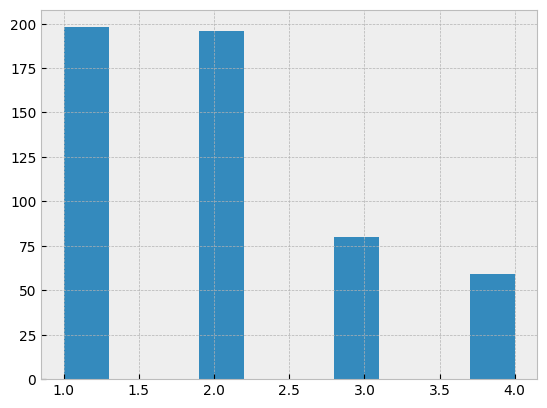

In [34]:
activities["Distance_cat"].hist()

Now you are ready to do stratified sampling based on the income category. For this
you can use Scikit-Learn’s StratifiedShuffleSplit class:

In [35]:
activities = activities.reset_index()

In [36]:
activities.pop('index')

0        0
1        2
2        5
3       12
4       13
      ... 
528    847
529    849
530    851
531    852
532    854
Name: index, Length: 533, dtype: int64

In [37]:
activities.head()

,Distance,Elevation Gain,Max Grade,Moving Time,Distance_cat
0,59.08,412.800842,9.4,10637.0,3
1,35.56,114.721718,11.1,5067.0,2
2,56.41,574.050659,11.9,11906.0,3
3,34.89,207.574387,10.6,4466.0,2
4,9.82,41.745453,6.6,1978.0,1


In [38]:
activities.index

RangeIndex(start=0, stop=533, step=1)

## Splitting Training and Test sets

Now it's time to get our Training and Test sets.

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(activities, activities["Distance_cat"]):
    strat_train_set_n = activities.iloc[train_index]
    strat_test_set_n = activities.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [40]:
print(len(strat_splits))
strat_train_set, strat_test_set = strat_splits[0]

10


In [41]:
strat_train_set.describe()

,Distance,Elevation Gain,Max Grade,Moving Time
count,426.000000,426.000000,426.000000,426.000000
mean,31.194437,427.087518,10.907744,4834.488263
std,22.266853,357.343806,5.223845,3569.244177
min,3.000000,0.000000,0.000000,308.000000
25%,13.300000,166.250000,7.167882,2313.750000
50%,26.435000,323.973526,11.079717,3982.500000
75%,40.350000,621.500000,14.300000,6044.250000
max,110.200000,2275.000000,24.799999,21230.000000


In [42]:
strat_test_set.describe()

,Distance,Elevation Gain,Max Grade,Moving Time
count,107.000000,107.000000,107.000000,107.000000
mean,31.043458,367.496713,9.784863,4523.859813
std,23.290602,351.910466,5.507412,3689.425285
min,4.260000,0.000000,0.000000,441.000000
25%,12.740000,84.500000,6.538627,1974.000000
50%,25.960000,265.904999,9.882262,3542.000000
75%,40.040000,521.036072,12.900000,5868.500000
max,118.010000,1570.000000,24.700001,17473.000000


It's much shorter to get a single stratified split:

In [43]:
strat_train_set, strat_test_set = train_test_split(
    activities, test_size=0.2, stratify=activities["Distance_cat"], random_state=42)

Let's extract the labels for the Training and Test sets

In [44]:
strat_train_set_labels=strat_train_set.pop("Moving Time")
print(type(strat_train_set_labels))

<class 'pandas.core.series.Series'>


In [45]:
strat_test_set_labels=strat_test_set.pop("Moving Time")

In [46]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 125 to 33
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Distance        426 non-null    float64 
 1   Elevation Gain  426 non-null    float64 
 2   Max Grade       426 non-null    float64 
 3   Distance_cat    426 non-null    category
dtypes: category(1), float64(3)
memory usage: 13.9 KB


In [47]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 307 to 317
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Distance        107 non-null    float64 
 1   Elevation Gain  107 non-null    float64 
 2   Max Grade       107 non-null    float64 
 3   Distance_cat    107 non-null    category
dtypes: category(1), float64(3)
memory usage: 3.6 KB


In [48]:
strat_train_set_labels.info()

<class 'pandas.core.series.Series'>
Int64Index: 426 entries, 125 to 33
Series name: Moving Time
Non-Null Count  Dtype  
--------------  -----  
426 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


In [49]:
strat_test_set_labels.info()

<class 'pandas.core.series.Series'>
Int64Index: 107 entries, 307 to 317
Series name: Moving Time
Non-Null Count  Dtype  
--------------  -----  
107 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [50]:
strat_test_set["Distance_cat"].value_counts() / len(strat_test_set)

1    0.373832
2    0.364486
3    0.149533
4    0.112150
Name: Distance_cat, dtype: float64

In [51]:
def distance_cat_proportions(data):
    return data["Distance_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(activities, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": distance_cat_proportions(activities),
    "Stratified %": distance_cat_proportions(strat_test_set),
    "Random %": distance_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Distance Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Distance Category,,,,,
1,37.15,37.38,35.51,0.63,-4.40
2,36.77,36.45,34.58,-0.88,-5.97
3,15.01,14.95,18.69,-0.37,24.53
4,11.07,11.21,11.21,1.31,1.31


In [52]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Distance_cat", axis=1, inplace=True)

Now we have a cleaned Training and Test sets. For the time being put aside the Test set and let's work only on the Training set.

## Feature Scaling

One of the most important transformations you need to apply to your data is feature
scaling. With few exceptions, Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales.

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
strat_train_set_norm = pd.DataFrame(scaler.fit_transform(strat_train_set), columns = strat_train_set.columns)
strat_train_set_norm.describe()
print("scaler mean {}".format(scaler.mean_))

test_scaler = StandardScaler()
strat_test_set_norm = pd.DataFrame(test_scaler.fit_transform(strat_test_set), columns = strat_test_set.columns)
strat_test_set_norm.describe()
print("test scaler mean {}".format(test_scaler.mean_))


scaler mean [ 31.19443662 427.08751833  10.90774396]
test scaler mean [ 31.04345794 367.4967128    9.78486283]


## Evaluation, prediction and printing functions

Before diving into the models training let's prepare a toolbox of functions that will come back to help to execute the prediction and the evaluation of a generic model. This will be helpful to collect the accuracy of each model in a dictionary and compare them later.

Let's define a dictionary to collect the model's data (model handler, cross validation scores, rmse...)

In [54]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

evaluations = {}
models = {}
class model_instance:
    def __init__(self, model):
        self.model = model
        self.name = type(model).__name__
        self.scores = None
        self.cross_val_score = 0
        self.training = {"accuracy": 0, "rmse": 0}
        self.test = {"accuracy": 0, "rmse": 0}
        self.cross_val_score = []
        self.cross_val_score_rms = []
        
    def prediction(self, moving_time, data):
        predicted_moving_time = self.model.predict(data)
        error = abs(100*(predicted_moving_time-moving_time)/moving_time)
        return predicted_moving_time, error
    
    def accuracy(self, dataset_name, dataset, dataset_labels):
        dataset_predictions = self.model.predict(dataset)
        if dataset_name == "training":
            self.training['accuracy'] = self.model.score(dataset, dataset_labels)
        elif dataset_name == "test":
            self.test['accuracy'] = self.model.score(dataset, dataset_labels)

    def rmse(self, dataset_name, dataset, dataset_labels):
        dataset_predictions = self.model.predict(dataset)
        if dataset_name == "training":
            self.training['rmse'] = np.sqrt(mean_squared_error(dataset_labels, dataset_predictions))
        elif dataset_name == "test":
            self.test['rmse'] = np.sqrt(mean_squared_error(dataset_labels, dataset_predictions))

    def print_model_accuracy(self, dataset_name):
        if dataset_name == "training":
            print("Model {}: Accuracy on {} set:{}".format(self.name, dataset_name, self.training['accuracy']))
        elif dataset_name == "test":
            print("Model {}: Accuracy on {} set:{}".format(self.name, dataset_name, self.test['accuracy']))
            
    def print_model_rmse(self, dataset_name):
        if dataset_name == "training":
            print("Model {}: Rmse on {} set:{}".format(self.name, dataset_name, self.training['rmse']))
        elif dataset_name == "test":
            print("Model {}: Rmse on {} set:{}".format(self.name, dataset_name, self.test['rmse']))

    def cross_val_score_eval(self, dataset, dataset_labels):
        self.cross_val_score = cross_val_score(self.model, dataset, dataset_labels, scoring="neg_mean_squared_error", cv=10)
        self.cross_val_score_rmse = np.sqrt(-self.cross_val_score)
        
    def print_model_cross_val_score(self):
        print("Cross Val Score {}".format(self.cross_val_score))
        print("Cross Val Rmse {}".format(self.cross_val_score_rmse))
        print("Mean:", self.cross_val_score_rmse.mean())
        print("Standard deviation:", self.cross_val_score_rmse.std())
        
    def plot_learning_curves(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        train_errors, val_errors = [], []
        for m in range(50, len(X_train)):
            self.model.fit(X_train[:m], y_train[:m])
            y_train_predict = self.model.predict(X_train[:m])
            y_val_predict = self.model.predict(X_val)
            train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))
        plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
        plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")


### Better Evaluation Using Cross-Validation
One way to evaluate a model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult and it would work fairly well.

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The code of the method 'cross_val_score_eval' randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores. This approach will be used to evaluate each model on the Training set.

## Linear Regression Model

We will created a fitted linear model using the formula API of the scikit-learn library.

In [55]:
linear_reg = LinearRegression()
linear_reg_name = type(linear_reg).__name__
models[linear_reg_name] = model_instance(linear_reg)

Let's train the Linear Regressor model on the stratified features and labels.

In [56]:
models[linear_reg_name].model.fit(strat_train_set_norm, strat_train_set_labels) 

LinearRegression()

### Linear Regressor Parameters 
The $\mathbf{w}$ and $\mathbf{b}$ parameters are referred to as 'coefficients' and 'intercept' in scikit-learn. In other term the model function can be written as $f_{w,b}(\vec{x})$

In [57]:
b = models[linear_reg_name].model.intercept_
w = models[linear_reg_name].model.coef_
print(f"w = {w:}, b = {b:0.2f}")

w = [2881.5956525   757.12999035  276.50789969], b = 4834.49


### Accuracy and  Root Mean squared error of the LinearRegressor Model

Let’s measure the regression model’s RMSE on the whole training set using the preiously defined function 'evaluation'.

In [58]:
models[linear_reg_name].accuracy("training", strat_train_set_norm, strat_train_set_labels)
models[linear_reg_name].rmse("training", strat_train_set_norm, strat_train_set_labels)
models[linear_reg_name].cross_val_score_eval(strat_train_set, strat_train_set_labels)

In [59]:
models[linear_reg_name].print_model_accuracy('training')

Model LinearRegression: Accuracy on training set:0.8857785383962287


In [60]:
models[linear_reg_name].print_model_rmse('training')

Model LinearRegression: Rmse on training set:1204.8688645372035


In [61]:
models[linear_reg_name].print_model_cross_val_score()

Cross Val Score [ -969997.06643991 -1323783.92240959  -873443.54616986  -919480.48857627
  -788231.32487029 -1503415.04571465  -636503.88242472 -5650529.74846294
 -1324418.39619765  -909541.53324813]
Cross Val Rmse [ 984.88429089 1150.55809171  934.58201682  958.89545237  887.82392673
 1226.13826533  797.81193425 2377.08429562 1150.83378304  953.69886927]
Mean: 1142.2310926035216
Standard deviation: 430.3982185617935


### Learning Curves of the Linear Regressor Model

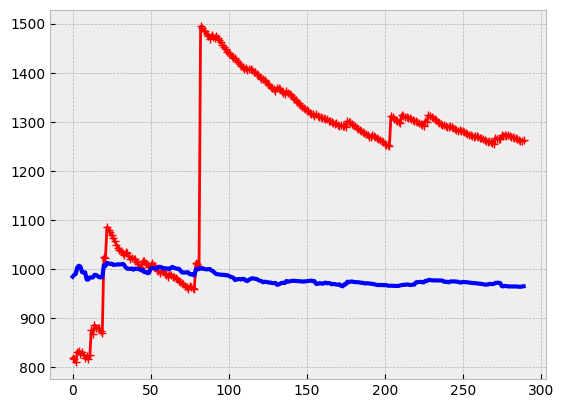

In [62]:
models[linear_reg_name].plot_learning_curves(strat_train_set_norm, strat_train_set_labels.ravel())

## Decision tree Model

In order to try to improve the accuracy on the Training set let's try a different model able to catch nonlinear patterns in the data.
Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data.

In [63]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg_name = type(tree_reg).__name__
models[tree_reg_name] = model_instance(tree_reg)

In [64]:
models[tree_reg_name].model.fit(strat_train_set_norm, strat_train_set_labels) 

DecisionTreeRegressor()

### Mean squared error and Accuracy of the Decision Tree Model

Let's evauluate the Accuracy and RMSE of the Decision Tree Model

In [65]:
models[tree_reg_name].accuracy("training", strat_train_set_norm, strat_train_set_labels)
models[tree_reg_name].rmse("training", strat_train_set_norm, strat_train_set_labels)
models[tree_reg_name].cross_val_score_eval(strat_train_set, strat_train_set_labels)

In [66]:
models[tree_reg_name].print_model_accuracy('training')

Model DecisionTreeRegressor: Accuracy on training set:1.0


In [67]:
models[tree_reg_name].print_model_rmse('training')

Model DecisionTreeRegressor: Rmse on training set:0.0


Not error at all on the Training data? At a first glance the Model seems to be perfect.
Of course, it is much more likely that the model has badly overfit the data. How can you be sure?
We'll use part of the training set for training, and part for model validation.


In [68]:
models[tree_reg_name].print_model_cross_val_score()

Cross Val Score [-1422830.39534884 -4143849.58139535 -1544115.69767442 -3808300.97674419
 -2827968.65116279 -2162006.20930233 -1102168.30952381 -6137119.85714286
 -1611930.04761905 -2138904.73809524]
Cross Val Rmse [1192.82454508 2035.64475815 1242.62451999 1951.48686307 1681.65651997
 1470.37621353 1049.84204027 2477.32110497 1269.61807156 1462.49948311]
Mean: 1583.3894119701342
Standard deviation: 427.54814519742496


Now the real nature of the Decision Tree has come to light. The mean RMSE is about 1500 secs and the Standard Deviation is around 470 secs. This is not so far from the Linear Regression Model.

The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

### Learning Curves for the Decision Tree Model

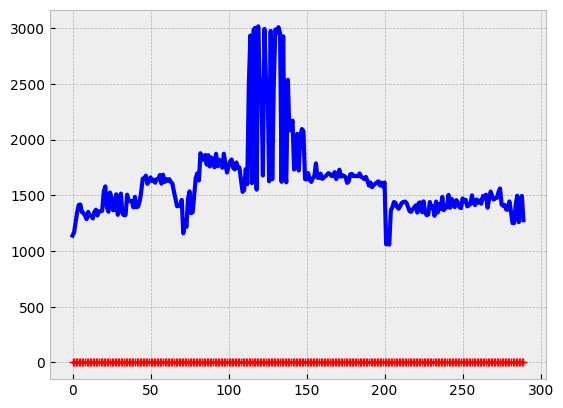

In [69]:
models[tree_reg_name].plot_learning_curves(strat_train_set_norm, strat_train_set_labels.ravel())

## Random Forest Model

Let’s try one last model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further.

In [70]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg_name = type(forest_reg).__name__
models[forest_reg_name] = model_instance(forest_reg)

In [71]:
models[forest_reg_name].model.fit(strat_train_set_norm, strat_train_set_labels) 

RandomForestRegressor()

### Mean squared error and Accuracy of the Random Forest Model

Let's evauluate the Accuracy and RMSE of the Random Forest Model

In [72]:
models[forest_reg_name].accuracy("training", strat_train_set_norm, strat_train_set_labels.ravel())
models[forest_reg_name].rmse("training", strat_train_set_norm, strat_train_set_labels.ravel())
models[forest_reg_name].cross_val_score_eval(strat_train_set, strat_train_set_labels.ravel())

In [73]:
models[forest_reg_name].print_model_accuracy('training')

Model RandomForestRegressor: Accuracy on training set:0.9833643144056232


In [74]:
models[forest_reg_name].print_model_rmse('training')

Model RandomForestRegressor: Rmse on training set:459.8183271130686


In [75]:
models[forest_reg_name].print_model_cross_val_score()

Cross Val Score [ -835275.51503953  -981484.22577442  -986510.64233488 -1720064.67656744
 -1375577.52399302 -1369833.72996047 -1216176.86609762 -5600951.86300238
 -1040317.6512      -841526.73379286]
Cross Val Rmse [ 913.93408681  990.69885726  993.23242111 1311.51236234 1172.85017116
 1170.39896188 1102.80409235 2366.63302246 1019.95963214  917.34766244]
Mean: 1195.9371269949147
Standard deviation: 408.05187299093683


Now it sounds better and more reasonable. The Standard Deviation decreased a bit if compared to the Decision Tree Model.

### Learning Curves for the Random Forest Model

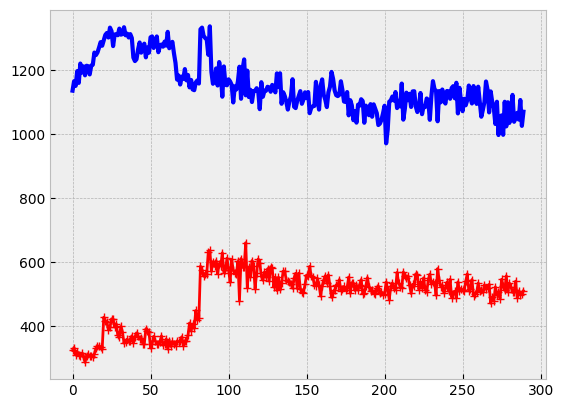

In [76]:
models[forest_reg_name].plot_learning_curves(strat_train_set_norm, strat_train_set_labels.ravel())

## Polynomial Model

In [77]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
degree=3
poly_reg=make_pipeline(PolynomialFeatures(degree),LinearRegression())

poly_reg_name = type(poly_reg).__name__
models[poly_reg_name] = model_instance(poly_reg)

In [78]:
models[poly_reg_name].model.fit(strat_train_set_norm, strat_train_set_labels) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

### Mean squared error and Accuracy of the Polynomial Regressor Model

In [79]:
models[poly_reg_name].accuracy("training", strat_train_set_norm, strat_train_set_labels)
models[poly_reg_name].rmse("training", strat_train_set_norm, strat_train_set_labels)
models[poly_reg_name].cross_val_score_eval(strat_train_set, strat_train_set_labels)

In [80]:
models[poly_reg_name].print_model_accuracy('training')

Model Pipeline: Accuracy on training set:0.9040845418397279


In [81]:
models[poly_reg_name].print_model_rmse('training')

Model Pipeline: Rmse on training set:1104.1046221356871


In [82]:
models[poly_reg_name].print_model_cross_val_score()

Cross Val Score [  -654200.36777264  -1441229.30299338   -761554.29507358
   -731889.95779812   -931366.25386895  -1393124.28272872
   -736886.2649675  -18055871.32551659  -1157632.13568716
   -753846.16384552]
Cross Val Rmse [ 808.82653751 1200.51210031  872.67078275  855.50567374  965.07318576
 1180.30685956  858.42079714 4249.22008438 1075.93314648  868.24314788]
Mean: 1293.4712315513393
Standard deviation: 994.3300298061394


### Learning Curves for the Polynomial Regression Model

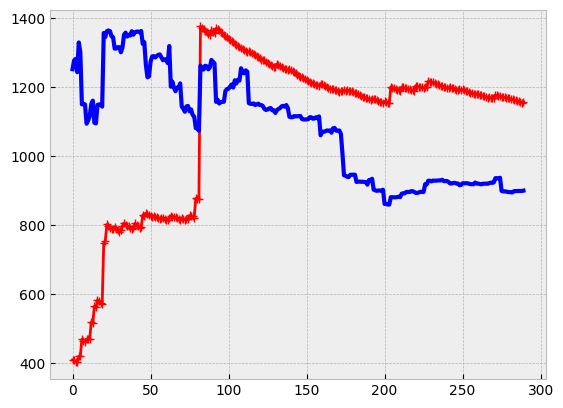

In [83]:
models[poly_reg_name].plot_learning_curves(strat_train_set_norm, strat_train_set_labels.ravel())

## Stochastic Gradient Descent Regressor

In [84]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000)
sgdr_reg_name = type(sgd_reg).__name__
models[sgdr_reg_name] = model_instance(sgd_reg)

In [85]:
models[sgdr_reg_name].model.fit(strat_train_set_norm, strat_train_set_labels)
print(f"number of iterations completed: {models[sgdr_reg_name].model.n_iter_}, number of weight updates: {models[sgdr_reg_name].model.t_}")

number of iterations completed: 34, number of weight updates: 14485.0


### Mean squared error and Accuracy of the SGD Regressor Model

In [86]:
models[sgdr_reg_name].accuracy("training", strat_train_set_norm, strat_train_set_labels.ravel())
models[sgdr_reg_name].rmse("training", strat_train_set_norm, strat_train_set_labels.ravel())
models[sgdr_reg_name].cross_val_score_eval(strat_train_set_norm, strat_train_set_labels.ravel())

In [87]:
models[sgdr_reg_name].print_model_accuracy('training')

Model SGDRegressor: Accuracy on training set:0.8857752014522087


In [88]:
models[sgdr_reg_name].print_model_rmse('training')

Model SGDRegressor: Rmse on training set:1204.8864643408276


In [89]:
models[sgdr_reg_name].print_model_cross_val_score()

Cross Val Score [ -967825.20429047 -1325706.080886    -877272.77879015  -913627.11437331
  -789257.05236728 -1506443.17498883  -630052.11511528 -5655664.28103991
 -1322339.20523007  -906233.45255025]
Cross Val Rmse [ 983.78107539 1151.39310441  936.6284102   955.83843529  888.40140273
 1227.37246791  793.75822208 2378.1640568  1149.93008711  951.96294705]
Mean: 1141.7230208950023
Standard deviation: 431.1735028054796


### Learning Curves for the SGD Regressor Model

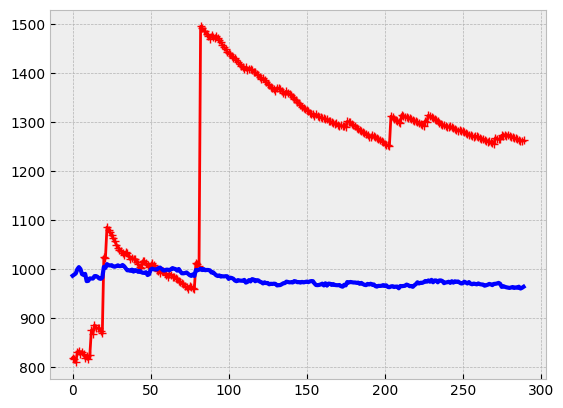

In [90]:
models[sgdr_reg_name].plot_learning_curves(strat_train_set_norm, strat_train_set_labels.ravel())

## Performance on the Test Set

In [91]:
for model in models.keys():
    models[model].accuracy("test", strat_test_set_norm, strat_test_set_labels.ravel())
    models[model].rmse("test", strat_test_set_norm, strat_test_set_labels.ravel())
    models[model].print_model_accuracy('test')
    models[model].print_model_rmse('test')
    print("")

Model LinearRegression: Accuracy on test set:0.9131828294575213
Model LinearRegression: Rmse on test set:1081.9883319844002

Model DecisionTreeRegressor: Accuracy on test set:0.8198218565317628
Model DecisionTreeRegressor: Rmse on test set:1558.7297248529608

Model RandomForestRegressor: Accuracy on test set:0.897145221187062
Model RandomForestRegressor: Rmse on test set:1177.6927483463064

Model Pipeline: Accuracy on test set:0.9237685574064078
Model Pipeline: Rmse on test set:1013.88064580473

Model SGDRegressor: Accuracy on test set:0.913302565215823
Model SGDRegressor: Rmse on test set:1081.2419508695482



## Challenge Gunsan-Saemangeum 2002 prediction

Let's try to predict the Moving Time of a new route I rode the last weew, the Challenge Gunsan-Saemangeum 2022.

The input data are:
- Distance: 30 Km's
- Elevation Gain: 26
- Max Grade: 3%

The real Moving Time is 53 minutes

<center><img src="gunsam.png" alt="Challenge Gunsan-Saemangeum 2022 - Rouvy" /><img src="test-route.png" alt="Challenge Gunsan-Saemangeum 2022" /></center>

In [92]:
gunsan_real_moving_time=53*60 # secs

In [93]:
#gunsan_route_data = pd.DataFrame({"Distance": [29.99], "Elevation Gain": [26], "Max Grade": [3]}, columns = strat_train_set.columns).to_numpy()
print(scaler.mean_)
gunsan_route_data = [[29.99, 26, 3]] # (strat_test_set_norm.iloc[-1,:])
gunsan_route_data_norm = test_scaler.transform(gunsan_route_data) #gunsan_route_data.reshape(1,-1)
print(type(gunsan_route_data_norm))
print((gunsan_route_data_norm))

gunsan_route_data_norm_df = pd.DataFrame(gunsan_route_data_norm, columns = strat_train_set.columns)
print(type(gunsan_route_data_norm_df))
print((gunsan_route_data_norm_df))

[ 31.19443662 427.08751833  10.90774396]
<class 'numpy.ndarray'>
[[-0.04544388 -0.9749746  -1.23774869]]
<class 'pandas.core.frame.DataFrame'>
   Distance  Elevation Gain  Max Grade
0 -0.045444       -0.974975  -1.237749


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Model's prediction comparison on the new route

Let's print out the predictions of the three models trained so far.

In [94]:
for model in models.keys():
    predicted_moving_time, error = models[model].prediction(gunsan_real_moving_time, gunsan_route_data_norm_df)
    print("Model {}: Moving time {} mins, error {} %:".format(models[model].name, predicted_moving_time/60, error))

Model LinearRegression: Moving time [61.29264585] mins, error [15.64650161] %:
Model DecisionTreeRegressor: Moving time [48.68333333] mins, error [8.14465409] %:
Model RandomForestRegressor: Moving time [48.7245] mins, error [8.06698113] %:
Model Pipeline: Moving time [55.67061831] mins, error [5.03890247] %:
Model SGDRegressor: Moving time [61.32022453] mins, error [15.69853685] %:


## Fine-Tune Your Model

 You now need to fine-tune the Random Forest. Let’s look at a few ways you can do that.

### Grid Search

One way to do that would be to fiddle with the hyperparameters manually, until you
find a great combination of hyperparameter values. This would be very tedious work,
and you may not have time to explore many combinations. 
Instead you should get Scikit-Learn’s GridSearchCV to search for you. All you need to
do is tell it which hyperparameters you want it to experiment with, and what values to
try out, and it will evaluate all the possible combinations of hyperparameter values,
using cross-validation. For example, the following code searches for the best combi‐
nation of hyperparameter values for the RandomForestRegressor:

In [95]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [96]:
grid_search = GridSearchCV(models[forest_reg_name].model, param_grid, cv=10,  scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(strat_train_set_norm, strat_train_set_labels)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [97]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [98]:
cvres = grid_search.cv_results_

In [99]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1449.0258355166018 {'max_features': 2, 'n_estimators': 3}
1318.400859224995 {'max_features': 2, 'n_estimators': 10}
1243.747624249938 {'max_features': 2, 'n_estimators': 30}
1398.6579518718795 {'max_features': 4, 'n_estimators': 3}
1346.4482756533823 {'max_features': 4, 'n_estimators': 10}
1292.1396045219003 {'max_features': 4, 'n_estimators': 30}
1483.6379725850645 {'max_features': 6, 'n_estimators': 3}
1278.4612740451357 {'max_features': 6, 'n_estimators': 10}
1290.853086852749 {'max_features': 6, 'n_estimators': 30}
1404.8916273859527 {'max_features': 8, 'n_estimators': 3}
1360.983825084745 {'max_features': 8, 'n_estimators': 10}
1287.76112914992 {'max_features': 8, 'n_estimators': 30}
1533.8274869310803 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
1390.9028458306739 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
1588.5456237181804 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
1598.5593487824385 {'bootstrap': False, 'max_features': 3, 'n_estim

In [100]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.73540412, 0.22387596, 0.04071992])

In [101]:
best_random_forest = grid_search.best_estimator_
best_random_forest_name = "BestRandomForest"
models[best_random_forest_name] = model_instance(best_random_forest)

In [102]:
models[best_random_forest_name].accuracy("test", strat_test_set_norm, strat_test_set_labels)
models[best_random_forest_name].rmse("test", strat_test_set_norm, strat_test_set_labels)
models[best_random_forest_name].print_model_accuracy('test')
models[best_random_forest_name].print_model_rmse('test')

Model RandomForestRegressor: Accuracy on test set:0.914673299083712
Model RandomForestRegressor: Rmse on test set:1072.6603825599245


In [103]:
predicted_moving_time, error = models[best_random_forest_name].prediction(gunsan_real_moving_time, gunsan_route_data_norm_df)
print("Model {}: Moving time {} mins, error {} %:".format(models[best_random_forest_name].name, predicted_moving_time/60, error))

Model RandomForestRegressor: Moving time [48.74277778] mins, error [8.03249476] %:


### Learning curves of the best Random Forest Model

Let’s look at the learning curves of the plain Best Random Forest

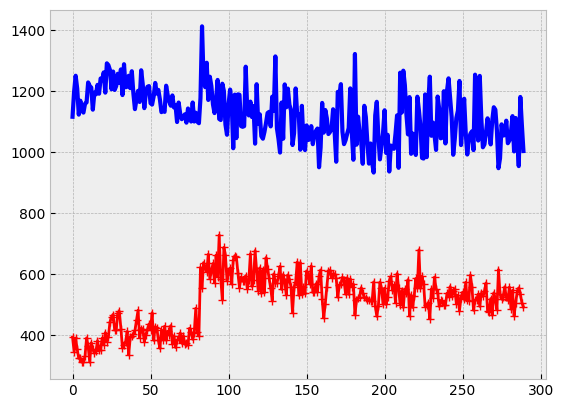

In [104]:
models[best_random_forest_name].plot_learning_curves(strat_train_set, strat_train_set_labels.ravel())

## Conclusions

The purpose of this exercise was to to develop a Machine Learning Model to predict the 'Moving Time' of a Route based on Rouvy data. 
- Data includes more of 500 'outdoor' and 'indoor' routes. 
- The 'indoor' routes have been exported by Rouvy to Strava.
- The 'outdoor' routes have been recorded directly by Strava
- The data have been cleaned and prepared for training.
- A Linear Regressor prooved to be good, but unable to perfectly fit the training dataset. The accuracy on the training was comparable with the test set one. There was room for some improvement. Maybe the linear model didn't fit at the best.
- The Decision Tree showed a worse result to predict the Moving time than the Linear Regressor. Likely it was overfitting the Training data.
- The Polynomial model gave the best results without hyperamaeters tuning
- The Random Forest prooved to be the best choice after a hyperparameters optimization (GridSearch) to minimize the prediction error on a new route not included nor in the Training set neither in the Test set.